# Outlier Detection Notebook - v.0

An outlying observation, or "outlier", is one that appears to deviate markedly from other members of the sample in which it occurs. For this code, we are going to use some general functions which will be listed as follow:

 ## 1. Basic Scripts

First, we import the libraries that will be used in the code.

In [1]:
%pylab inline
import pandas as pd
import scipy.stats as ss
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import statsmodels.api as sm
import time
import seaborn as sns
from sklearn.neighbors import KernelDensity

Populating the interactive namespace from numpy and matplotlib


The **``fn_sinusoid()``** function generates a sinusoidal series in order to simulate the seasonality of the natural time series.

In [2]:
def fn_sinusoid(a=1, w=12, n=1200, b=0):
    """
    This function generates a sinusoidal series
    :param a: amplitude.
    :param w: period.
    :param n: samples.
    :param b: intercept.
    :return:
    """
    return [b + a * np.sin(w * x) for x in range(n)]

In [3]:
%timeit fn_sinusoid()

100 loops, best of 3: 3.42 ms per loop


The **``fn_generator()``** function generates a series with three components, the first one is related to the seasonal component, the second one is related to the error (white noise), and finally, the last one is related to handled outliers. You could choose the distribution, we tried with **``norm``**, **``gumbel_r``** and **``gumbel_l``** distributions from the [**``scipy.stats``**](http://docs.scipy.org/doc/scipy/reference/tutorial/stats/continuous.html) package. When we use the **``norm``** distribution, we could see the error as white noise ($\mu=0$, $\sigma=1$).

In [4]:
def fn_sr2mg(sr_ts):
    """
    This function transforms a time series into a dataframe monthly grouped.
    :param sr_ts: pandas time series to be transformed.
    :return: pandas dataframe monthly grouped.
    """
    df_data = pd.DataFrame(sr_ts)
    df_data['year'] = df_data.index.year
    df_data['month'] = df_data.index.month
    df_mg = df_data.pivot(index='year', columns='month', values=sr_ts.name)
    return df_mg

def fn_mg2sr(mg_input):
    """
    This function transforms a dataframe monthly grouped into a time series.
    :param mg_input: pandas dataframe monthly grouped to be transformed.
    :return: pandas time series.
    """
    start_date = pd.datetime(mg_input.index.min(), 1, 1)
    end_date = pd.datetime(mg_input.index.max(), 12, 1)
    sr_try = mg_input.unstack()
    sr_try.index.levels[0].name = 'month'
    df_try = sr_try.reset_index()
    df_try['Date'] = pd.to_datetime(df_try['year'].astype('str') + df_try['month'].astype('str'), format="%Y%m")
    df_try.set_index(df_try['Date'], inplace=True)
    df_try.drop(['year', 'month', 'Date'], axis=1, inplace=True)
    df_try.sort_index(inplace=True)
    index_output = pd.DatetimeIndex(freq='MS', start=start_date, end=end_date, name='Date')
    sr_output = df_try.loc[index_output, 0]
    return sr_output

In [5]:
def fn_generator(longitude=1200, p_outlier=0.05, m_outlier=5, dist='norm'):
    """
    This function generates a series with two components, the first one is related to the the error, and the second one is
    related to handled outliers.
    :param longitude: size of the sample to generate.
    :param p_outlier: fraction of handled outliers.
    :param m_outlier: magnitude of handled outliers.
    :return: pandas dataframe including all the components of the series.
    """
    index_data = pd.DatetimeIndex(freq='MS', start=pd.datetime(1930, 1, 1), periods=longitude, name='Date')
    sr_error = pd.Series(getattr(ss, dist).rvs(size=longitude), index=index_data, name='error', dtype=np.float64)
    mg_error = fn_sr2mg(sr_error)
    sr_dev = mg_error.std() * m_outlier
    sr_marked = pd.Series(index=index_data, name='outliers')
    sr_sample = sr_error.sample(frac=p_outlier)
    sr_marked.loc[sr_sample.index] = sr_sample
    mg_marked = fn_sr2mg(sr_marked)
    mg_outliers = mg_marked + sr_dev * mg_marked.abs() / mg_marked
    mg_error.update(mg_outliers)

    return mg_error, mg_outliers

Date
1931-07-01    3.744587
1932-12-01    3.820662
1955-02-01   -2.734026
1955-07-01   -3.142079


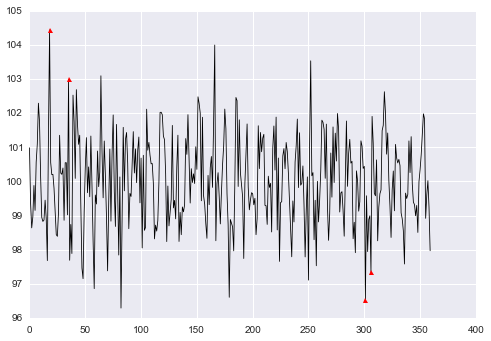

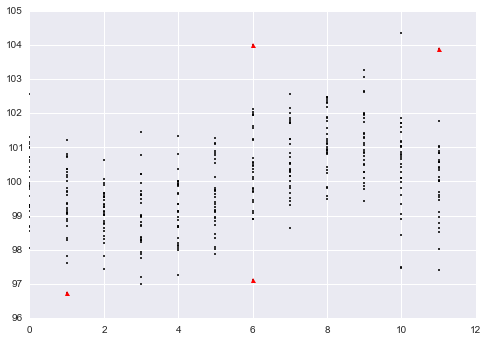

In [6]:
mg_data, mg_marked = fn_generator(longitude=360, p_outlier=0.01, m_outlier=3)
sr_base = fn_sinusoid(n=360, b=100)

sr_marked = fn_mg2sr(mg_marked)
print sr_marked.dropna().to_string()

plt.plot(fn_mg2sr(mg_data) + sr_base, '-k', linewidth=.8)
plt.plot(sr_marked + sr_base, '^r', markersize=5)
plt.show()

plt.plot([sr_base[x - 1] + mg_data[x] for x in mg_data.columns], '.k', markersize=4)
plt.plot([sr_base[x - 1] + mg_marked[x] for x in mg_marked.columns], 'r^', markersize=5)
plt.show()

The **``fn_count``** counts the successful detections and also the unsuccessful detections, these last arranged in two groups: false negatives and false positives. The first ones are related to the values that are outliers and haven't been detected by the method, the last ones are related to the values that aren't outliers but have been detected as one.

In [7]:
def fn_count(df_marked, df_detected, print_results=False):
    """
    This function count positives, false negatives and false positives detected as outliers.
    :param df_marked: pandas dataframe with the values marked originally as outliers.
    :param df_detected: pandas dataframe with the values detected as outliers by the different methods. 
    :return:
    """
    positives = (df_marked == df_detected)[(df_marked == df_detected)].count().sum()
    false_negatives = df_marked[(df_marked != df_detected) & (df_marked != np.nan)].count().sum()
    false_positives = df_detected[(df_marked != df_detected) & (df_marked != np.nan)].count().sum()
    
    if print_results:
        # print '\nCounting Results\n'
        print '\nPositives:      ', str(positives)
        print 'False Negatives:', str(false_negatives)
        print 'False Positives:', str(false_positives)
        
    return [positives, false_negatives, false_positives]

In [8]:
# %timeit fn_count()

The next two functions are used for applying the ***Kolmogorov-Smirnov Test***. <small>(*We have to optimize these codes.*)<small>

In [9]:
def ckolmo(obs):
    """
    implementa p(lamda)
    Obs es el valor de lamda empirico
    Definicion de los niveles de significancia
    """
    # vns = [0.4000, 0.3000, 0.2000, 0.1000, 0.0500, 0.0250, 0.0100, 0.0050, 0.0010, 0.0005]
    vns = [obs]
    lvns = len(vns)
    ckd = []
    for i in range(lvns):
        ckd.append([0])
    for i in range(lvns):
        ckd[i] = (-np.log(vns[i] / 2.0) / np.log(np.e) / 2.0) ** (1 / 2.0)
    return ckd


def fn_testkolmogorov(pe, pt, alfa=0.05):
    """
    pe prob excedencia empirica
    pt prob excedencia teorica
    alfa nivel de significacion de la prueba
    res = 1 la hipotesis no se rechaza; res = 0 La hipotesis se rechaza
    """
    D = np.max(np.abs(pe - pt))
    lamda = D * np.sqrt(np.size(pe, axis=0))  # lamda es el lamda empirico
    # print lamda
    lamdat = ckolmo(alfa)
    # print 'lamdas=', lamdat, lamda
    if lamda <= lamdat:
        res = True
    else:
        res = False
    return res

Through the next functions, we try to adjust our data to almost all continuous probability functions that are included in the **``scipy.stats``** module, we could use these in multiprocess mode in order to reduce the running time just by setting the **``multiprocessing``** flag to **``True``**. In despite of these functions haven't been used in the main code, it is a good tool for adjusting functions later.

In [10]:
def fn_core_adjust_cdf(fdist, sr_adjust, sr_empirical):
    df_results = pd.DataFrame()
    cur_dist = getattr(ss, fdist)
    pars = cur_dist.fit(sr_adjust)
    sr_dist = cur_dist.cdf(sr_adjust, *pars)
    df_results.loc[fdist, 'kst'] = fn_testkolmogorov(sr_empirical, sr_dist, .1)
    df_results.loc[fdist, 'mare'] = np.mean(np.abs(sr_empirical - sr_dist) / sr_empirical)
    return sr_dist, df_results


def fn_adjust(sr_input, multiprocessing=False):
    sel_dist = [d for d in dir(ss) if isinstance(getattr(ss, d), ss.rv_continuous)]
    rem_dist = ['beta', 'dweibull', 'erlang', 'gausshyper', 'ksone', 'levy_stable', 'betaprime', 'mielke', 'ncf', 'nct',
                'ncx2', 'tukeylambda']  # Series to remove from distribution list.
    for remove in rem_dist:
        sel_dist.remove(remove)

    cols_dist = pd.Index(['empirical'] + sel_dist, name='dist')
    index_dist = pd.Index(range(sr_input.size), name='order')
    df_dist = pd.DataFrame(index=index_dist, columns=cols_dist)
    sr_input.order(ascending=True, inplace=True)
    sr_input.reset_index(drop=True, inplace=True)
    df_dist['empirical'] = np.array(range(1, sr_input.size + 1)) / (sr_input.size + 1.)
    cols_results = pd.Index(['kst', 'mare'])
    df_results = pd.DataFrame(index=sel_dist, columns=cols_results)
    # df_plot = pd.DataFrame(index=sr_input.index, columns=cols_dist)

    partial_dist = ft.partial(fn_core_adjust_cdf, sr_adjust=sr_input, sr_empirical=df_dist['empirical'])

    if multiprocessing:
        pool = mp.Pool()
        results = pool.map(partial_dist, sel_dist)
        pool.close()
        pool.join()
    else:
        results = map(partial_dist, sel_dist)

    for result in results:
        df_single = result[1]
        if df_single['kst'][0]:
            sr_dist = pd.Series(result[0], index=sr_input.index, name=df_single.index[0])
            # df_plot.update(sr_dist)
            df_results.update(result[1])

    df_results.dropna(inplace=True)
    df_results.sort(['mare'], inplace=True)
    # df_plot.dropna(axis=1, inplace=True)
    return df_results

 ## 2. Grubbs' Test

The [Grubbs' Test](http://www.real-statistics.com/students-t-distribution/identifying-outliers-using-t-distribution/grubbs-test/) is frequently used for detecting outliers in data normally distributed (except for the outliers). However, this test has been used in an undiscriminating manner without taking account its restrictions. The test estimates a statistic value $G$, for suspected maximum values, 
$$G = \frac{x_{max} - \bar x}{s}$$


and for suspected minimum values,
$$G = \frac{\bar x - x_{max}}{s}$$

where:
$\bar x$ is the average of the data including the suspect value.
$s$ is the standar deviation of the data including the suspect value.
$x_{max}$ and $x_{min}$ are the suspect values.

The $G$ value is compared with the critical value of the test, which is estimated by mean of:

$$G_{crit} = \frac{(n - 1) t_{crit}}{\sqrt{n(n - 2 + t_{crit}^{2})}}$$

Where $t_{crit}$ is the critical value of the ***t distribution*** and the significance level is $\alpha/n$. Thus the null hypothesis is rejected if $G > G_{crit}$.


In [11]:
def fn_grubbs(df_input, alpha=0.01, two_tail=True):
    """
    This function applies the Grubbs' Test for outliers in a dataframe and returns two dataframes, the first one
    without outliers and the second one just for the outliers
    :param df_input: Pandas dataframe with series to test.
    :param alpha: Significance level [1% as default].
    :param two_tail: Two tailed distribution [True as default].
    :return: tuple with two dataframes, the first one without outliers and the second one just for outliers.
    """
    df_try = df_input.copy()
    df_output = pd.DataFrame(index=df_input.index, columns=df_input.columns)
    df_outliers = pd.DataFrame(data=0, index=df_input.index, columns=df_input.columns)
    if two_tail:
        alpha /= 2

    while not df_outliers.isnull().values.all():
        mean = df_try.mean()
        std = df_try.std()
        n = len(df_try)
        tcrit = ss.t.ppf(1 - (alpha / (2 * n)), n - 2)
        zcrit = (n - 1) * tcrit / (n * (n - 2 + tcrit ** 2)) ** .5
        df_outliers = df_try.where(((df_try - mean) / std) > zcrit)
        df_output.update(df_input[df_outliers.isnull() == False])
        df_try = df_try[df_outliers.isnull()]

    return df_try, df_output

For determining the normality of the data, we could use the Shapiro-Wilk test, which is already implemented in the **``scipy.stats``** module.

In [12]:
mg_clean, mg_outliers = fn_grubbs(mg_data)
print "Results of the Grubbs' Test"
print "\nOutliers detected:", fn_mg2sr(mg_outliers).dropna().to_string()
results= fn_count(mg_marked, mg_outliers, True)

print "\nShapiro Test:", [ss.shapiro(mg_clean[month].dropna())[1] > .05 for month in range(1, 13)]

Results of the Grubbs' Test

Outliers detected: Series([], Freq: MS)

Positives:       0
False Negatives: 4
False Positives: 0

Shapiro Test: [True, True, True, True, True, True, True, True, True, True, True, True]


As we can see, we couldn't use the **Grubbs' Test** with the whole data set.

 # 3. Kullback-Leibler Distance Method

This method has been proposed for detecting outliers in hydrometeorological time series, and as the header said, it's based on the [*Kullback-Leibler Distance*](http://mathworld.wolfram.com/RelativeEntropy.html) (***KLD***):

$$
d = \sum_k{p_k \log_2 \frac{p_k}{q_k}}
$$

Where $p_k$, $q_k$ are probability functions and $d(p,q) \not= d(q,p)$. So, the first step for calculating the KLD is to estimate the probabilities $p_k$ and $q_k$, and we have chosen the [*Kernel Density Estimation*](https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/) for this purpose.

## 3.1. Kernel Density Estimation

In statistics, kernel density estimation (***KDE***) is a non-parametric way to estimate the probability density function of a random variable. In Python, there are four implementations that allow estimate the KDE:
- In [SciPy](http://scipy.org): [``gaussian_kde``](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html).

- In [Statsmodels](http://statsmodels.sourceforge.net/): [``KDEUnivariate``](http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/kernel_density.html) and [``KDEMultivariate``](http://statsmodels.sourceforge.net/devel/generated/statsmodels.nonparametric.kde.KDEUnivariate.html).

- In [Scikit-learn](http://scikit-learn.org): [``KernelDensity``](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html).

<small>
***Note:*** *This information has been taken from [Jake VanderPlas website](https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/), and some codes has been adapted to our case.*
</small>

Next, we present the python code for the available implementations of KDE.

In [13]:
def kde_scipy(x, **kwargs):
    kde = ss.gaussian_kde(x, **kwargs)
    return kde


def kde_statsmodels_u(x, **kwargs):
    kde = sm.nonparametric.KDEUnivariate(x)
    kde.fit(**kwargs)
    return kde


def kde_statsmodels_m(x, **kwargs):
    kde = sm.nonparametric.KDEMultivariate(x, var_type='c', **kwargs)
    return kde


def kde_sklearn(x, **kwargs):
    kde_skl = KernelDensity(**kwargs)
    kde_skl.fit(x[:, np.newaxis])
    return kde_skl

These four implementations have different purposes, and their performance is variable depending on multiple issues. For our case, we're going to assess the performance for two data sets, which are presented in the next section.

## 3.2. Proposed Method

The data set generated previously (**``df_data``**) has to be divided in data sets, wich must fulfill the independent and identically distributed (**iid**) condition. We can get these data sets by taking monthly groups (for each month of the year), thus we have twelve data sets per data serie. In order to check if the last data sets are iid, we could try for testing randomness with the *Runs Test*, for example. For each data set iid, we estimate the distances vector, which is composed by the absolute value of the distance of each value with each others,  thus, if the data set has $n$ elements, the distances vector will have $\frac{n!}{((n - 2)! \times 2!)}$ data:

$$
\begin{align}
d_{i, j} = \lvert{x_{i} - x_{j}}\lvert, & \text{ } & \forall(i \not= j)
\end{align}
$$

In addition, there are $n$ data sets that must be estimated too, one per each data in the data set iid. Each one of these data sets includes the distances between itself and each others. Each new data set will have $n−1$ values. The next function (``fn_distance``) calculates the data set of distances, but as you can notice, this function has to be run as many times as data there are (n).

In this way, we have two types of data sets, a big one with the distances of the whole data set, and $n$ small ones with the distances for each data in the iid data set. So, we are going to test which KDE implementation is the most efficient for this purpose.

In [14]:
def fn_distance(sr_input, index):
    """
    This function calculates distances between one data with each others.
    :param sr_input: series to calculate the distances.
    :param index: index of data to calculate the distances.
    :return: series with distances.
    """
    data = sr_input.iloc[index]
    sr_distance = (sr_input.drop(sr_input.index[index]) - data).abs()
    return sr_distance

n: 30
Size of the data set: (435, 12)
Month: 1
Month: 2
Month: 3
Month: 4
Month: 5
Month: 6
Month: 7
Month: 8
Month: 9
Month: 10
Month: 11
Month: 12


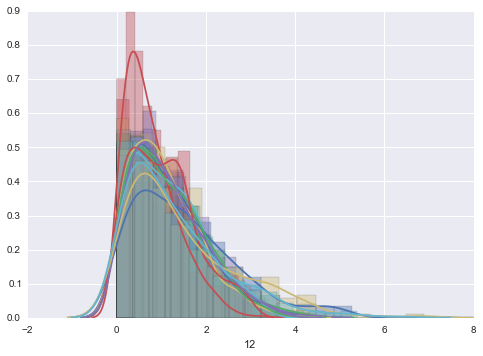

In [15]:
ix_data = mg_data.index
len_data = len(ix_data)
df_distance = pd.DataFrame(columns=mg_data.columns)
for data in range(mg_data.shape[0]):
    df_distance = df_distance.append((mg_data.iloc[data + 1:] - mg_data.iloc[data]).abs())

print "n:", len_data
print "Size of the data set:", df_distance.shape

months = range(1, 13)
for month in months:
    print 'Month:', month
    sns.distplot(df_distance[month])

The next code estimates the running time of each KDE implementation in order to identify the most efficient way for calculating the PDF. We notice that the implementation depends on the amount of data, so we decided to use the [Statsmodels](http://statsmodels.sourceforge.net/) [``KDEUnivariate``](http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/kernel_density.html), as it works fine for big and small datasets. Thus, this impletation will be used for testing the method.

Month: 1

Theoretical:
Statsmodels_M    0.001267
Statsmodels_U    0.000200
Scipy_stats      0.001567
Scikit_learn     0.001467

Empirical:
Statsmodels_M    0.001700
Statsmodels_U    0.000833
Scipy_stats      0.000867
Scikit_learn     0.000400
Month: 2
1955


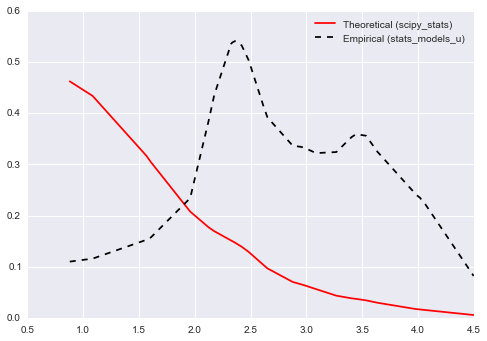


Theoretical:
Statsmodels_M    0.001867
Statsmodels_U    0.000600
Scipy_stats      0.001067
Scikit_learn     0.000933

Empirical:
Statsmodels_M    0.001767
Statsmodels_U    0.000233
Scipy_stats      0.001033
Scikit_learn     0.000367
Month: 3

Theoretical:
Statsmodels_M    0.001933
Statsmodels_U    0.000533
Scipy_stats      0.001033
Scikit_learn     0.001033

Empirical:
Statsmodels_M    0.001567
Statsmodels_U    0.000467
Scipy_stats      0.000833
Scikit_learn     0.000600
Month: 4

Theoretical:
Statsmodels_M    0.002033
Statsmodels_U    0.000567
Scipy_stats      0.001067
Scikit_learn     0.000867

Empirical:
Statsmodels_M    0.001533
Statsmodels_U    0.000567
Scipy_stats      0.000833
Scikit_learn     0.000567
Month: 5

Theoretical:
Statsmodels_M    0.001967
Statsmodels_U    0.000567
Scipy_stats      0.001067
Scikit_learn     0.001000

Empirical:
Statsmodels_M    0.001567
Statsmodels_U    0.000500
Scipy_stats      0.001000
Scikit_learn     0.000833
Month: 6

Theoretical:
Statsmodels_M 

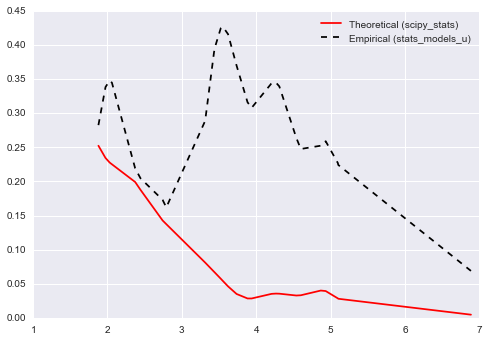

1955


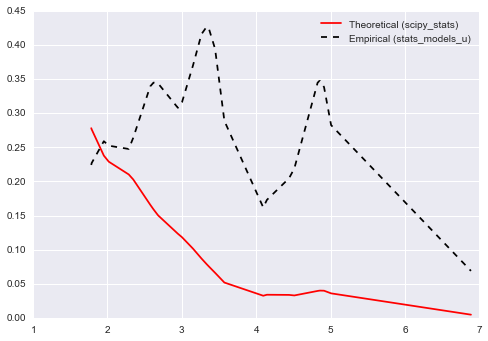


Theoretical:
Statsmodels_M    0.002267
Statsmodels_U    0.000400
Scipy_stats      0.001200
Scikit_learn     0.001100

Empirical:
Statsmodels_M    0.001833
Statsmodels_U    0.000733
Scipy_stats      0.001100
Scikit_learn     0.000700
Month: 8

Theoretical:
Statsmodels_M    0.001933
Statsmodels_U    0.000567
Scipy_stats      0.001200
Scikit_learn     0.001167

Empirical:
Statsmodels_M    0.001733
Statsmodels_U    0.000633
Scipy_stats      0.001000
Scikit_learn     0.000633
Month: 9

Theoretical:
Statsmodels_M    0.001933
Statsmodels_U    0.000267
Scipy_stats      0.001167
Scikit_learn     0.000967

Empirical:
Statsmodels_M    0.001567
Statsmodels_U    0.000500
Scipy_stats      0.000933
Scikit_learn     0.000567
Month: 10

Theoretical:
Statsmodels_M    0.001900
Statsmodels_U    0.000333
Scipy_stats      0.001033
Scikit_learn     0.001033

Empirical:
Statsmodels_M    0.001467
Statsmodels_U    0.000567
Scipy_stats      0.001000
Scikit_learn     0.000700
Month: 11

Theoretical:
Statsmodels_

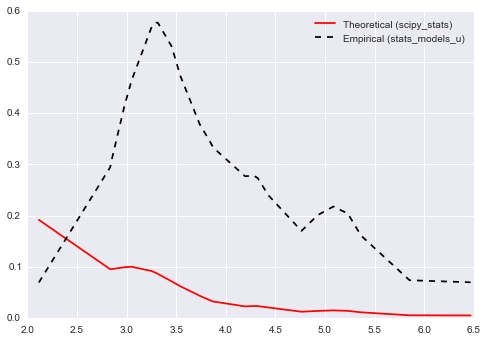


Theoretical:
Statsmodels_M    0.001833
Statsmodels_U    0.000433
Scipy_stats      0.001067
Scikit_learn     0.000933

Empirical:
Statsmodels_M    0.001467
Statsmodels_U    0.000633
Scipy_stats      0.000900
Scikit_learn     0.000733


In [16]:
bandwidth = 0.2

for month in months:
    print 'Month:', month
    sr_data_month = mg_data[month]
    sr_distance_month = df_distance[month].values
    time_11 = time.time()
    kde_ext_ss = kde_scipy(sr_distance_month, bw_method=bandwidth / sr_distance_month.std(ddof=1))
    time_12 = time.time()
    kde_ext_smu = kde_statsmodels_u(sr_distance_month, bw=bandwidth)
    time_13 = time.time()
    kde_ext_smm = kde_statsmodels_m(sr_distance_month, bw=bandwidth * np.ones_like(sr_distance_month))
    time_14 = time.time()
    kde_ext_skl = kde_sklearn(sr_distance_month, bandwidth=bandwidth, rtol=0.01)
    time_15 = time.time()

    sc_1 = time_12 - time_11
    smu_1 = time_13 - time_12
    smm_1 = time_14 - time_13
    skl_1 = time_15 - time_14
    dict_times_1 = {"Scipy_stats": sc_1, "Statsmodels_U": smu_1, "Statsmodels_M": smm_1, "Scikit_learn": skl_1}
    min_1 = min(dict_times_1, key=dict_times_1.get)
    # print "\nFitting external distance:", min_1, "=", dict_times_1[min_1]
    # print "scipy:", time_12 - time_11
    # print "statsmodels_u:", time_13 - time_12
    # print "statsmodels_m:", time_14 - time_13
    # print "sklearn:", time_15 - time_14

    sr_kld = pd.Series(index=sr_data_month.index)
    na_emp = pd.DataFrame(columns=dict_times_1.keys())
    na_the = pd.DataFrame(columns=dict_times_1.keys())
    for year, n_data in zip(ix_data, range(len_data)):
        na_distance_int = fn_distance(sr_data_month, n_data)
        na_distance_int.sort()

        time_21 = time.time()
        the_dist_ss = kde_ext_ss.evaluate(na_distance_int)
        time_22 = time.time()
        the_dist_smu = kde_ext_smu.evaluate(na_distance_int.values)
        time_23 = time.time()
        the_dist_smm = kde_ext_smm.pdf(na_distance_int)
        time_24 = time.time()
        the_dist_skl = np.exp(kde_ext_skl.score_samples(na_distance_int[:, np.newaxis]))
        time_25 = time.time()

        sc_2 = time_22 - time_21
        smu_2 = time_23 - time_22
        smm_2 = time_24 - time_23
        skl_2 = time_25 - time_24
        dict_times_2 = {"Scipy_stats": sc_2, "Statsmodels_U": smu_2, "Statsmodels_M": smm_2, "Scikit_learn": skl_2}
        na_the = na_the.append(dict_times_2, ignore_index=True)
        # min_2 = min(dict_times_2, key=dict_times_2.get)
        # print "Theoretical distance:", min_2, "=", dict_times_2[min_2]
        # print "scipy:", sc_2
        # print "statsmodels_u:", smu_2
        # print "statsmodels_m:", smm_2
        # print "sklearn:", skl_2

        # # Plot theoretical distance distribution for the different kde methods
        # plt.plot(na_distance_int, the_dist_ss, '-r')
        # plt.plot(na_distance_int, the_dist_smu, '-b')
        # plt.plot(na_distance_int, the_dist_smm, '-m')
        # plt.plot(na_distance_int, the_dist_skl, '-k')
        # plt.legend(['scipy', 'statsmodels_u', 'statsmodels_m', 'scikit_learn'])
        # plt.show()

        time_31 = time.time()
        kde_int_ss = kde_scipy(na_distance_int, bw_method=bandwidth / na_distance_int.std(ddof=1))
        emp_dist_ss = kde_int_ss.evaluate(na_distance_int)
        time_32 = time.time()
        kde_int_smu = kde_statsmodels_u(na_distance_int, bw=bandwidth)
        emp_dist_smu = kde_int_smu.evaluate(na_distance_int.values)
        time_33 = time.time()
        kde_int_smm = kde_statsmodels_m(na_distance_int, bw=bandwidth * np.ones_like(na_distance_int))
        emp_dist_smm = kde_int_smm.pdf(na_distance_int)
        time_34 = time.time()
        kde_int_skl = kde_sklearn(na_distance_int, bandwidth=bandwidth, rtol=0.01)
        emp_dist_skl = np.exp(kde_int_skl.score_samples(na_distance_int[:, np.newaxis]))
        time_35 = time.time()

        sc_3 = time_32 - time_31
        smu_3 = time_33 - time_32
        smm_3 = time_34 - time_33
        skl_3 = time_35 - time_34
        dict_times_3 = {"Scipy_stats": sc_3, "Statsmodels_U": smu_3, "Statsmodels_M": smm_3, "Scikit_learn": skl_3}
        na_emp = na_emp.append(dict_times_3, ignore_index=True)
        # min_3 = min(dict_times_3, key=dict_times_3.get)
        # print "Empirical distance:", min_3, "=", dict_times_3[min_3]
        # print "scipy:", sc_3
        # print "statsmodels_u:", smu_3
        # print "statsmodels_m:", smm_3
        # print "sklearn:", skl_3

        # Plot empirical distance distribution for the different kde methods
        # plt.plot(na_distance_int, the_dist_ss, '-r')
        # plt.plot(na_distance_int, the_dist_smu, '-b')
        # plt.plot(na_distance_int, the_dist_smm, '-m')
        # plt.plot(na_distance_int, the_dist_skl, '-k')
        # plt.legend(['scipy', 'statsmodels_u', 'statsmodels_m', 'scikit_learn'])
        # plt.show()

        if year in mg_marked[month].dropna().index:
            print year
            plt.plot(na_distance_int, the_dist_ss, "-r")
            plt.plot(na_distance_int, emp_dist_smu, "--k")
            plt.legend(["Theoretical (scipy_stats)", "Empirical (stats_models_u)"])
            plt.show()

    # results= fn_count(mg_marked, mg_outliers, True)

    print "\nTheoretical:\n", na_the.mean().to_string()
    print "\nEmpirical:\n", na_emp.mean().to_string()

***This part of the text was written for a dataset of 1200 samples, when we try the same exercise with 300 samples, the results were different.***

We can notice that for the biggest data set (Theoretical), the [SciPy](http://scipy.org) [``gaussian_kde``](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html) implementation is the fastest one, and for the small data set (Empirical), the [Statsmodels](http://statsmodels.sourceforge.net/) [``KDEUnivariate``](http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/kernel_density.html) is the best option. Thus, these impletations will be used for testing the method.

With these results, we are going to do 1000 trials in order to determine if the method could be applied for determining outliers in hydrometeorological time series.

Now, we have to identify what is the most accurate cutoff in order to catch the outliers values.